### Reproducing the PROPER Microscope Example with POPPY



Given a two lens optical system viewed by the human eye and a point source much closer than infinity, find the PSF seen on the retina, neglecting real lens shapes or variation in index of refraction. 

This is re-implimentation of the optical prescription describe on p.56 of the PROPER V2.0 manual by John Krist (http://sourceforge.net/projects/proper-library/). 
The PROPER 2.0 microscope.pro example was used for comparison with the following inputs:

    gridsize=512
    sampling=1
    wavelength=675e-9



An ASCII schematic illustrates this layout (on no particular scale):

o <--(objective)--------><---(eyepiece)---><--(eye)-->retina

where o is the object, (objective) is the objective lens and > indicates the direction of beam convergence (thus >< indicates an intermediate focus.

The system is held fixed and the distance from the object to the objective lens can be found using the thin lens equation:

$1/o+1/i=1/f$

${o}=\frac{1}{1/f-1/i}=\frac{if}{f-i}$



In [4]:
#Relation of POPPY debugging terms to PROPER terms:

#|PROPER           | POPPY| description|
#|Rayleigh distance| z_R  | location of the waist w_0|
#|Gaussian R_beam  |  R_c | gaussian beam radius of curvature    |
#|Beam diameter    |   2 * (spot_radius)| waist at a particular location|


In [12]:
import numpy as np

#plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline

#units
from astropy import units as u

#POPPY
import poppy
from poppy.poppy_core import PlaneType
poppy.__version__

'0.5.0'

#Define the optical elements:

In [6]:
from poppy import fresnel
#define system with units
diam = 0.005*u.m
fl_objective = 0.010*u.m
d1 = 0.160*u.m #
beam_ratio = 0.4
npix=512
d_intermediate_image = fl_objective + d1
d_object = 1.0 / (1/fl_objective - 1/d_intermediate_image)
d_object,d_intermediate_image#+d_object

#initialize optical elements:
source=poppy.QuadraticLens(-(d_object),name='source')
obj=poppy.QuadraticLens(fl_objective,name='objective')
eyepiece=poppy.QuadraticLens( 0.020*u.m,name='eyepiece')
eye=poppy.QuadraticLens( 0.022*u.m,name='eye')


## Manually step through each element of the system in a PROPER-like sequence

Oversampling > 2x suggested for reliable results.


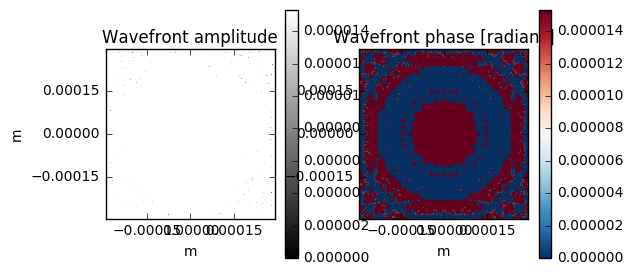

In [7]:
#intialize wavefront
micro_wf=fresnel.FresnelWavefront(diam/2.,wavelength=675e-9,
                              npix=npix,oversample=1)

micro_wf.normalize() 
#Input Pupil, this is where I'm applying the beam ratio, which almost matches the PROPER beam_diam_fraction approach
micro_wf *= poppy.CircularAperture(radius=diam.value/2.0*.4,
                             oversample=micro_wf.oversample)

#apply source curvature
micro_wf.apply_lens_power(source)
micro_wf.apply_lens_power(obj)

micro_wf.propagate_fresnel(d_intermediate_image+eyepiece.fl, display_intermed=False)

#show wavefront before eyepiece
micro_wf.display('both',colorbar=True)

micro_wf.apply_lens_power(eyepiece)  

exit_pupil_distance = eyepiece.fl / (1 - eyepiece.fl/(d_intermediate_image+eyepiece.fl))
micro_wf.propagate_fresnel(exit_pupil_distance)
micro_wf.apply_lens_power(eye)

micro_wf.propagate_fresnel(eye.fl, display_intermed=False)


# Compare to PROPER result

/Users/edouglas/anaconda3/envs/poppy-dev/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/edouglas/anaconda3/envs/poppy-dev/lib/python3.5/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/edouglas/anaconda3/envs/poppy-dev/lib/python3.5/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


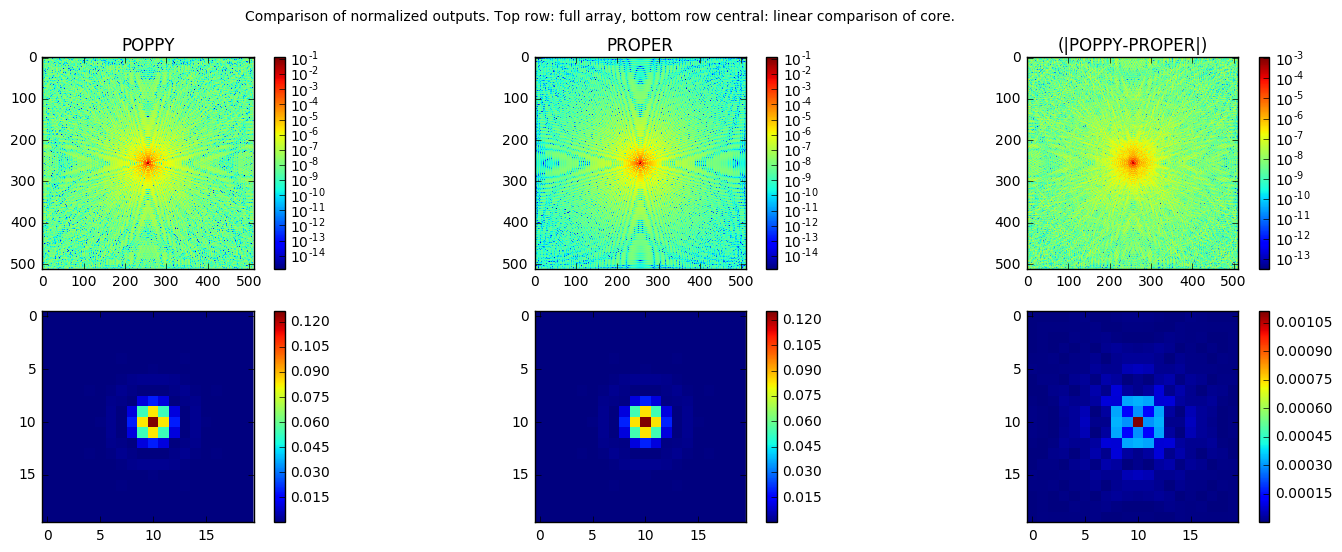

In [15]:
micro_wf.normalize()
plt.figure(figsize=[18,6])
poppy_image=poppy.utils.removePadding(micro_wf.intensity,micro_wf.oversample)
plt.subplot(231)
poppy_norm=LogNorm(vmax=poppy_image.max(),vmin=micro_wf.intensity.min())
cen=micro_wf.intensity.shape[0]/2.0

plt.imshow(micro_wf.intensity,interpolation='none',norm=poppy_norm)
plt.title("POPPY")

plt.colorbar()
plt.subplot(234)
plt.imshow(micro_wf.intensity[-10+cen:+10+cen,-10+cen:+10+cen],interpolation='none')
plt.colorbar()
try:
    import scipy.io
    plt.subplot(232)
    proper_micro=scipy.io.readsav('microscope_out.sav',)
    proper_intens=proper_micro.wavefront/proper_micro.wavefront.sum()
    proper_norm=LogNorm(vmax=proper_intens.max(),vmin=proper_intens.min())
    plt.imshow(proper_intens,interpolation='none',norm=proper_norm)
    plt.colorbar()

    plt.title("PROPER")
    diff=np.abs(micro_wf.intensity-proper_intens)
    diff_norm=LogNorm(vmax=diff.max(),vmin=diff.min())

    plt.subplot(233)
    plt.imshow(diff,norm=diff_norm)
    plt.title("(|POPPY-PROPER|)")
    plt.colorbar()
    plt.subplot(235)

    plt.imshow(proper_intens[-10+cen:+10+cen,-10+cen:+10+cen],interpolation='none')#,norm=proper_norm)
    plt.colorbar()


    plt.subplot(236)
    plt.imshow(diff[-10+cen:+10+cen,-10+cen:+10+cen],interpolation='none')#,norm=diff_norm)
    plt.colorbar()
except Exception as err:
    print(err)

plt.suptitle("Comparison of normalized outputs. Top row: full array, bottom row central: linear comparison of core.")


The agreement is better than 1%, the difference is likely due to POPPY's current lack of anti-aliased aperture edges (https://github.com/mperrin/poppy/issues/129)

### Implement the same system as a POPPY-like optical system.


In [16]:
#define powered optics
micro = poppy.FresnelOpticalSystem(pupil_diameter=diam, npix=512,beam_ratio=1)
micro.add_optic(poppy.CircularAperture(radius=diam.value/2*.4))
micro.add_optic(source)
micro.add_optic(obj)
micro.add_optic(eyepiece, distance=d_intermediate_image+eyepiece.fl)
micro.add_optic(eye, distance=exit_pupil_distance)

#the detector plane type needs to be intermediate,
# since the image plane type makes the astro-centric assumption that sources are at infinity
micro.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                         name="Retina"), distance=eye.fl);
micro.describe()

	Entrance pupil diam:  0.005 m	npix: 512	Beam ratio:1
	Optic: Circle, radius=0.001 m
	Lens: source, with focal length -0.010624999999999999 m
	Lens: objective, with focal length 0.01 m
	Propagation distance:  0.19 m
	Lens: eyepiece, with focal length 0.02 m
	Propagation distance:  0.02235294117647059 m
	Lens: eye, with focal length 0.022 m
	Propagation distance:  0.022 m
	Optic: Retina


## Show that is equivalent to the early line-by-line approach

Oversampling > 2x suggested for reliable results.


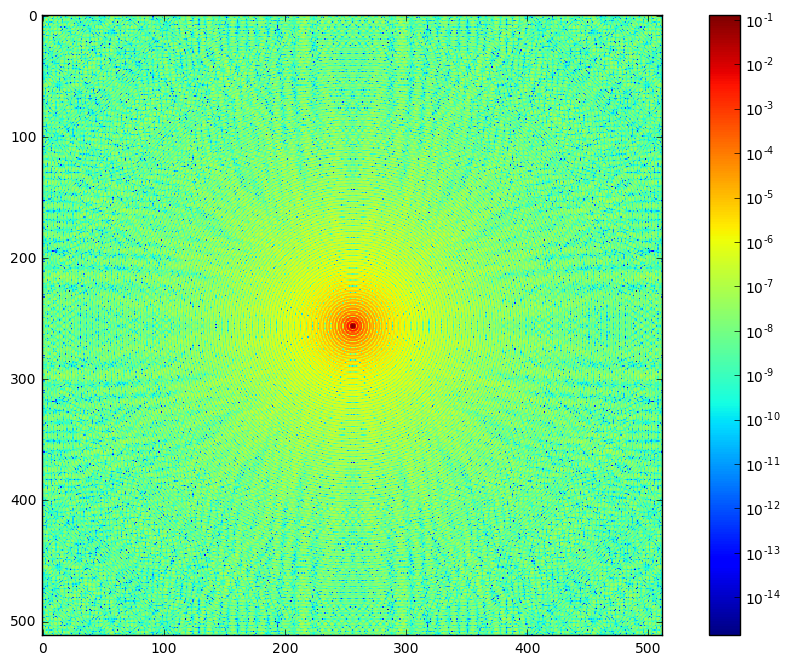

In [14]:
plt.figure(figsize=(12,8))
psf,waves = micro.calcPSF(wavelength=675e-9, 
                           display_intermediates=False, 
                           return_intermediates=True,
                          )

poppy_norm=LogNorm(vmax=psf[0].data.max(),vmin=psf[0].data.min())

plt.imshow(psf[0].data,interpolation='none',norm=poppy_norm)
plt.colorbar()

## Show that the sequential and optical system approaches are equivalent

/Users/edouglas/anaconda3/envs/poppy-dev/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


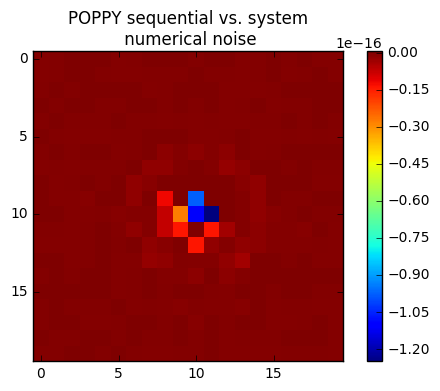

In [17]:
difference=micro_wf.intensity-psf[0].data
plt.imshow(difference[-10+cen:+10+cen,-10+cen:+10+cen],interpolation='none')
plt.title("POPPY sequential vs. system\n numerical noise")
plt.colorbar()

## Show how a microscope breaks the focal length to image plane  plate scale

In [18]:

for w in waves:
    print("Focal length {} is {}".format(w.location, w.focal_length))

Focal length after Circle, radius=0.001 m is inf m
Focal length after source is -0.010624999999999999 m
Focal length after objective is 0.17000002268060155 m
Focal length after eyepiece is -61.81180188255829 m
Focal length after eye is 0.0 m
Focal length after Retina is 0.0 m
